In [45]:
import seaborn as sns
import json
import pandas as pd
from numpy import average
import matplotlib as plt

In [53]:
translate_b =  {"histogram":"Histogram", "merge_sort":"Merge Sort","lu_decomposition":"LU Decomposition",
    "quadrature":"Quadrature", "monte_carlo":"Monte Carlo","needleman_wunsch":"Needleman-Wunsch"}

In [20]:
def avg(l):
    return average(l).item()

In [21]:
with open("../saved_suite_history.json") as f:
    data = json.load(f)

In [ ]:
y_omp = [avg(data[d]["omp_compiletime"]) for d in data]
y_rust = [avg(data[d]["rust_compiletime"]) for d in data]
[value for pair in zip(y_omp,y_rust) for value in pair]

[(0.12, 15.176666666666668), (0.12, 15.133333333333333), (0.88, 15.269999999999998), (1.07, 10.700000000000001), (0.11, 15.393333333333333), (0.15, 10.766666666666666)]


[0.12,
 15.176666666666668,
 0.12,
 15.133333333333333,
 0.88,
 15.269999999999998,
 1.07,
 10.700000000000001,
 0.11,
 15.393333333333333,
 0.15,
 10.766666666666666]

In [56]:
benchmarks = data.keys()
y_omp = [avg(data[d]["omp_compiletime"]) for d in benchmarks]
y_rust = [avg(data[d]["rust_compiletime"]) for d in benchmarks]

df = pd.DataFrame({"metric_val": [value for pair in zip(y_omp,y_rust) for value in pair] ,
                    "language":["OpenMP","Rust"] * len(data),
                    "benchmark":[translate_b[b] for b in benchmarks for _ in (0, 1)]
                    })

/tmp/ipykernel_2504727/789725701.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


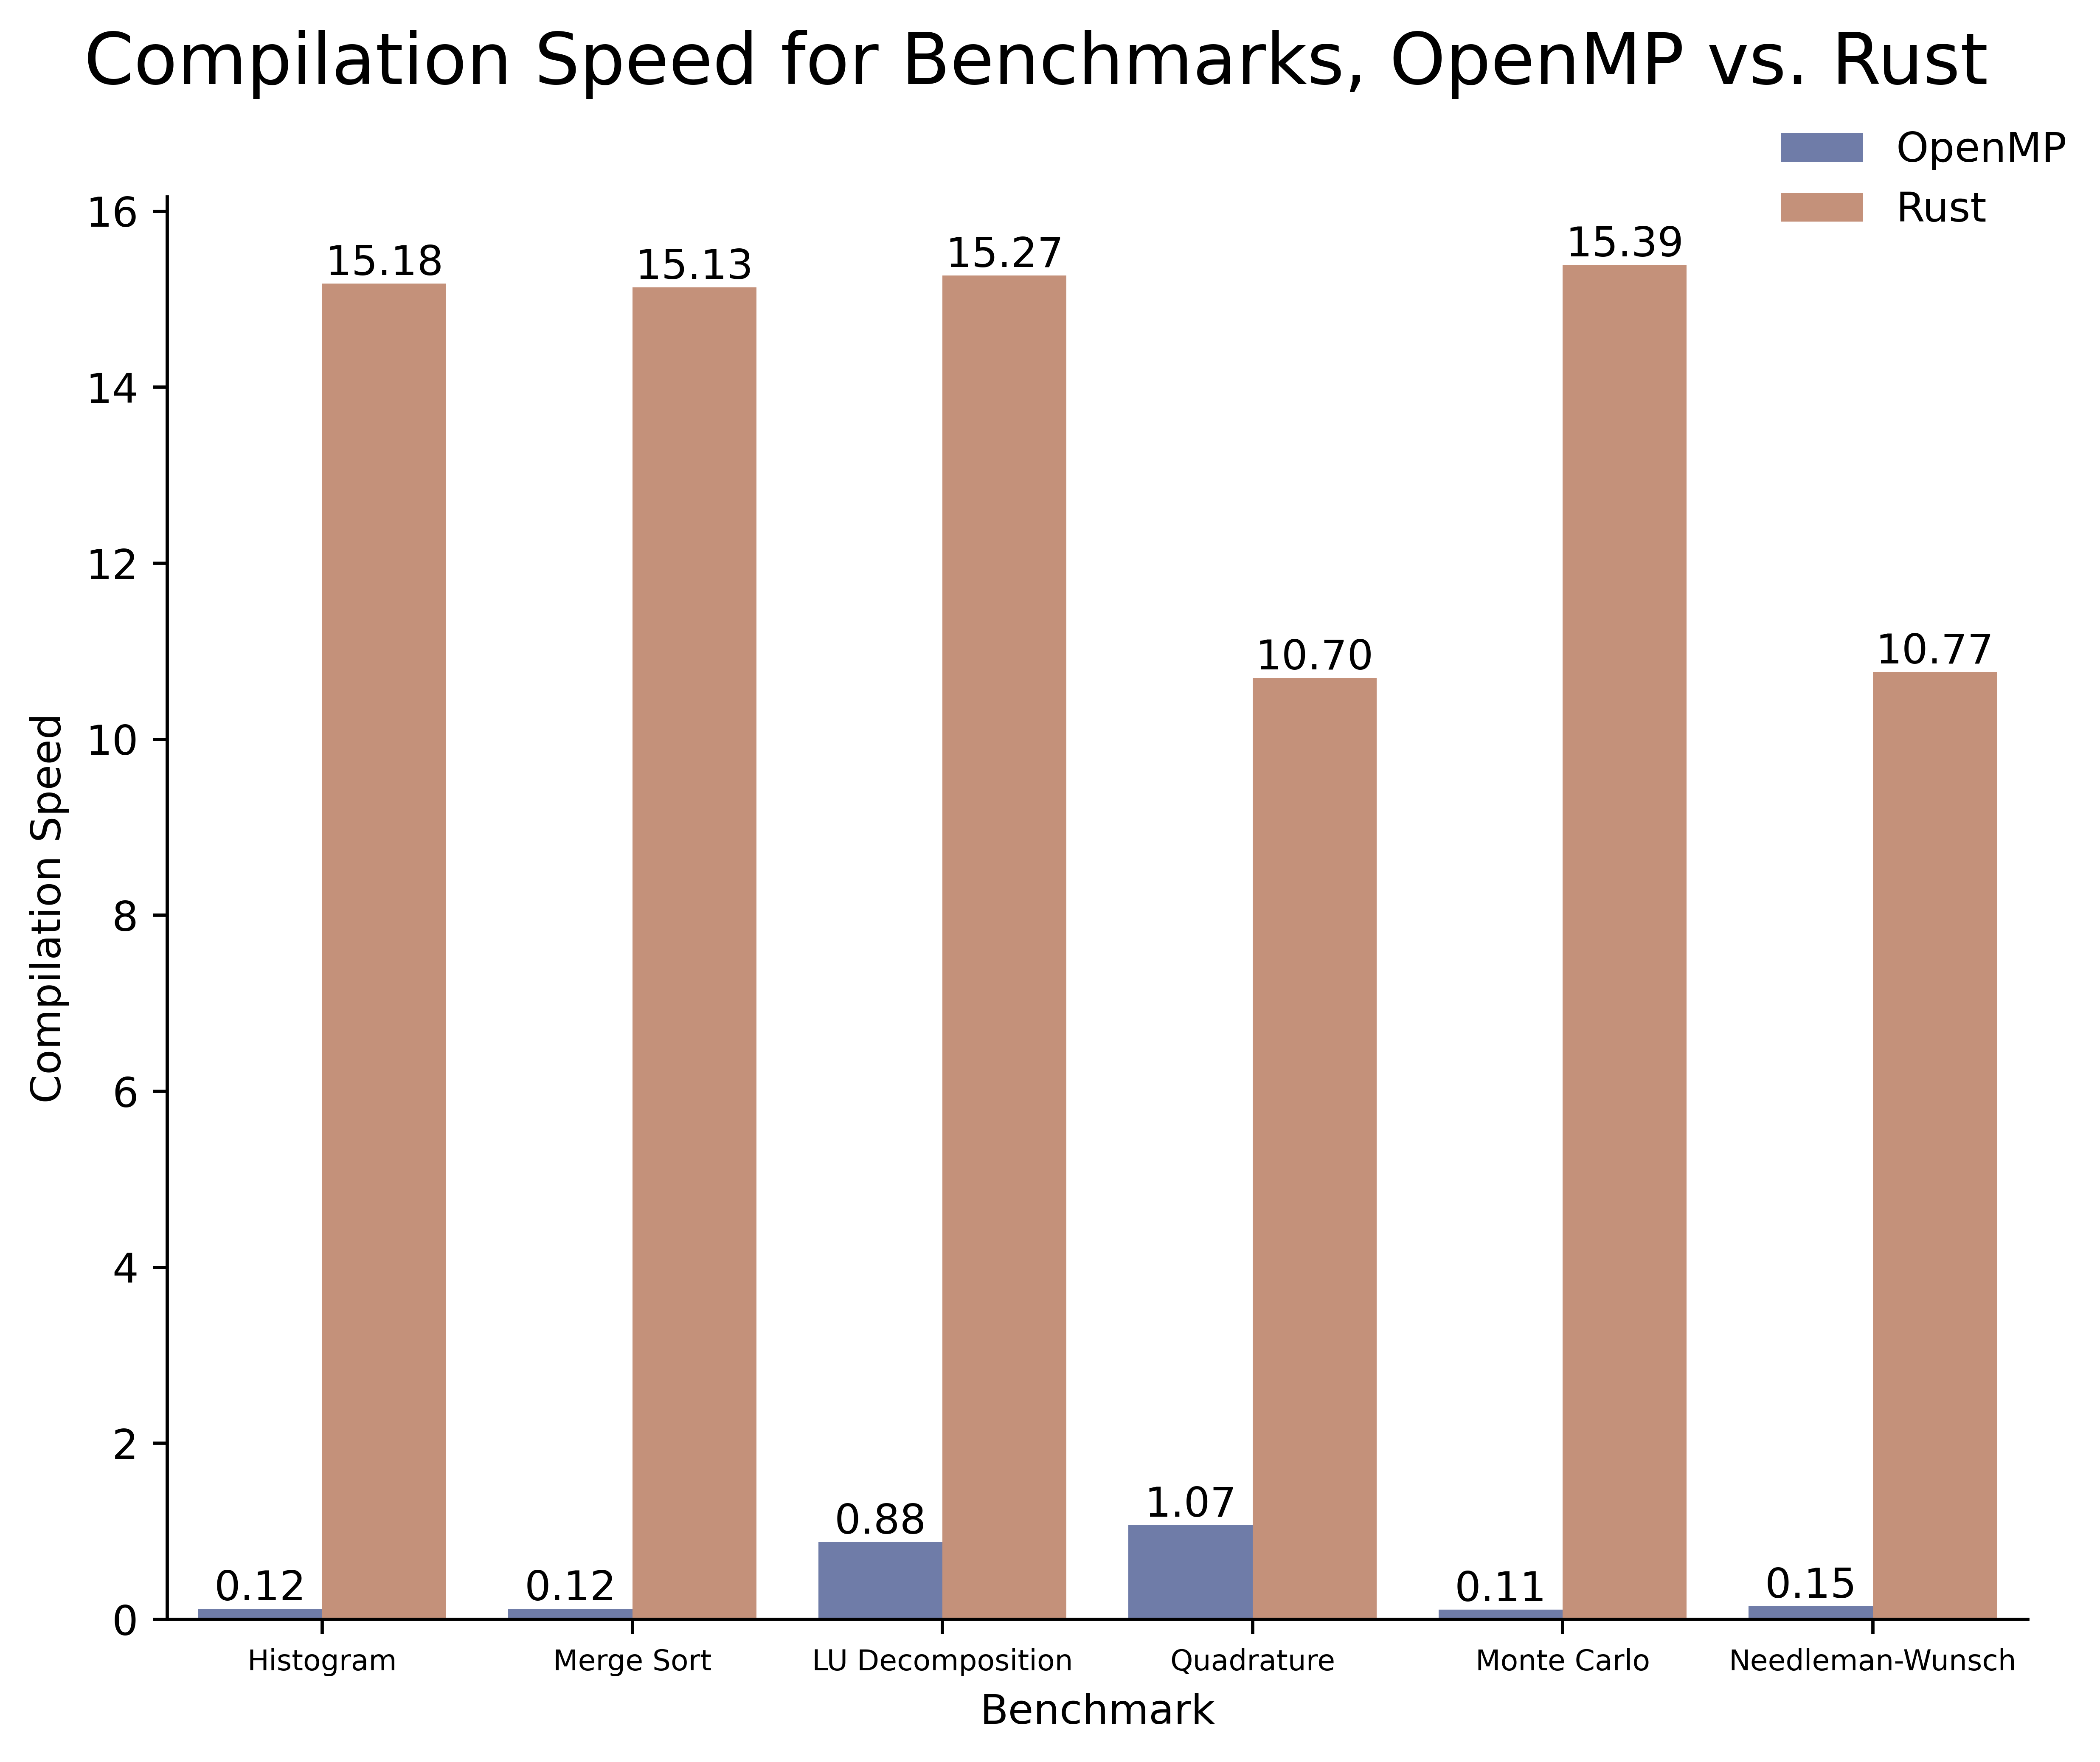

In [63]:
plt.rcParams.update({"figure.dpi": 700})
metric_axis_label = "Compilation Speed"
sup_title = "Compilation Speed for Benchmarks, OpenMP vs. Rust"
g: sns.FacetGrid = sns.catplot(
        data=df, kind="bar",
        x="benchmark", y="metric_val", hue="language",
        palette=sns.color_palette("dark")[0:2], alpha=.6, #height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        height = 6,
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, col_wrap=1,
    )
g.set_axis_labels("Benchmark", metric_axis_label)
g.legend.set_title("")
g.figure.suptitle(sup_title, fontsize="xx-large")

ax = g.axes.flat[0]
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}' for v in c]
    # ax.bar_label(c, labels=labels, label_type='edge')
    ax.bar_label(c, labels=labels, label_type="edge", )
g.figure.tight_layout(rect=[0, 0, 1, 0.975])
g.legend.set_loc((0.84,0.86))

In [44]:
        # intermediate_l = []


        # for d in (y_app,y_high,y_funded):
        #     intermediate_outer_l.append([''] + [f'{(y1 - y0) / y0 * 100:+.2f}%' for y0, y1 in zip(d[:-1], d[1:])])
        #     intermediate_inner_l.append([f'{yi:.{inner_decimals}f}\n{inner_label}' for yi in d])
        # labels.append((intermediate_outer_l, intermediate_inner_l))

        # for d in (y_app,y_high,y_funded):
        #     intermediate_l.append((
        #         [''] + [f'{(y1 - y0) / y0 * 100:+.2f}%' for y0, y1 in zip(d[:-1], d[1:])],
        #         [f'{yi:.{inner_decimals}f}{f"\n{inner_label}" if inner_label else ""}' for yi in d]
        #     ))

    plt.rcParams.update({"figure.dpi": 500})
    results_df = pd.concat(intermediate_dfs)
    g: sns.FacetGrid = sns.catplot(
        data=results_df, kind="bar",
        x="rel_year", y="metric_val", hue="status_type", col="award_type",
        palette=sns.color_palette("dark")[0:3], alpha=.6, height=15 / len(titles) * 2, aspect=len(titles) * 1.46666667 / 2, 
        # palette=sns.color_palette("dark")[0:3], alpha=.6, height=7, aspect=2.6, 
        sharex=False, sharey= sharey, col_wrap=1,
    )
    # ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

    for ax, l, a_t in zip(g.axes.flat, labels,titles):
        ax.set_title(title_format.format(award_t=a_t),fontsize=17)
        for container, con_labels in zip(ax.containers, l):
            ax.bar_label(container, con_labels[0], label_type="edge")
            ax.bar_label(container, con_labels[1], color="white", label_type="center", )
    # # iterate through the axes containers
    # for c,d in zip(ax.containers,(y_app,y_high,y_funded)):
        
    #     ax.bar_label(c, [''] + [f'{(y1 - y0) / y0 * 100:+.2f}%' for y0, y1 in zip(d[:-1], d[1:])], label_type="edge")
    #     ax.bar_label(c,  [f'{yi:.{inner_decimals}f}\n{inner_label}' for yi in d], color="white", label_type="center", )
    # g.despine(left=True)
    g.set_axis_labels("Relative Year to Damon Runyon application/funding", metric_axis_label)
    g.legend.set_title("")
    g.legend.set_loc((0.88,0.96))
    for t,l in zip(g.legend.get_texts(), g.legend.legend_handles):
        t.set_fontsize("large")
        l.set_height(10)
        l.set_width(24)
    g.figure.suptitle(sup_title, fontsize="xx-large")

    g.figure.tight_layout(rect=[0, 0, 1, 0.975])
    if filename:
        g.figure.savefig(os.path.join("metric_figs",filename),bbox_inches="tight")

IndentationError: unexpected indent (1735409077.py, line 15)